In [1]:
import time
start_time=time.time()

In [2]:
import sys
from pathlib import Path
import json
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import strucfunc
from strucfunc import sosflog
import bfunc

In [3]:
# Input fit files
name = 'O_III-5007'
flux    = fits.open('linesum-' + name + '.fits')
rad_vel = fits.open('mean-' + name + '-patfixx.fits')

In [4]:
# Region propertires
dist   = 410   # distance [parsecs]
pix    = 0.2 # spatialscale [arcsec per pixel]

# Observation propertires
seeing = 0.9   # FWHM seeing [arcsec] 

# Conversions
pc = dist * ( 2 * np.pi ) / (360 * 60 * 60) # value in parsecs of each arcsec
s0 = (seeing  * pc) / 2.355 # RMS seeing [parsecs]
pc , s0

(0.0019877360925490972, 0.0007596443665792729)

In [5]:
sb = flux[0].data.astype(float)
vv = rad_vel[0].data.astype(float)

In [6]:
## Replace spurious values in the arrays
m = ~np.isfinite(sb*vv) | (sb < 0.0)

sb[m] = 0.0
vv[m] = np.nanmean(vv)
sb /= sb.max()

good = (~m) & (sb > 0.001)

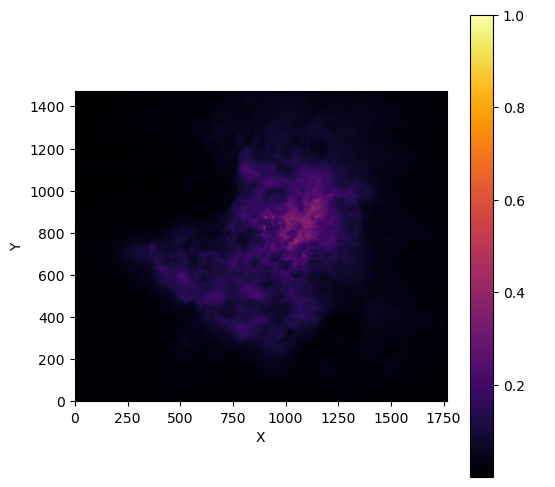

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.figure(1)
plt.imshow(sb, cmap='inferno')

cbar = plt.colorbar()
plt.clim(0.001,1)
cbar.set_label(' ', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

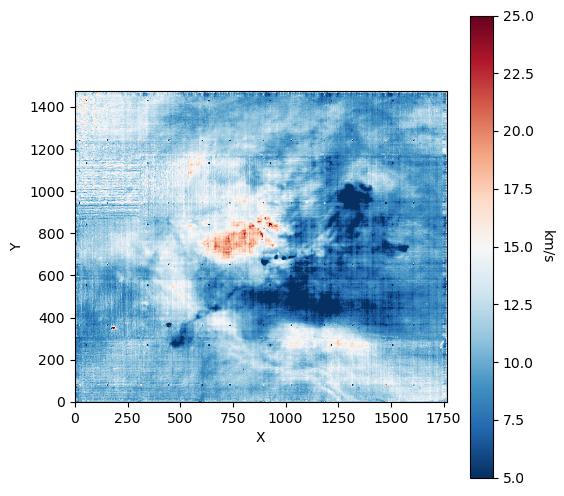

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.figure(1)
plt.imshow(vv, cmap='RdBu_r')

cbar = plt.colorbar()
plt.clim(5,25)
cbar.set_label('km/s', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

In [9]:
sb_df       = pd.DataFrame(sb)
sb_df       = sb_df.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'I'})
vv_df       = pd.DataFrame(vv)
data        = vv_df.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'RV'})
data['I']   = sb_df.I
data.describe()

,X,Y,RV,I
count,2.606616e+06,2.606616e+06,2.606616e+06,2.606616e+06
mean,7.375000e+02,8.825000e+02,1.064102e+01,5.314578e-02
std,4.260845e+02,5.098003e+02,1.585972e+01,5.720242e-02
min,0.000000e+00,0.000000e+00,-8.256324e+03,0.000000e+00
25%,3.687500e+02,4.410000e+02,8.715178e+00,1.626202e-02
50%,7.375000e+02,8.825000e+02,1.060893e+01,2.906343e-02
75%,1.106250e+03,1.324000e+03,1.247826e+01,7.283305e-02
max,1.475000e+03,1.765000e+03,1.887998e+04,1.000000e+00


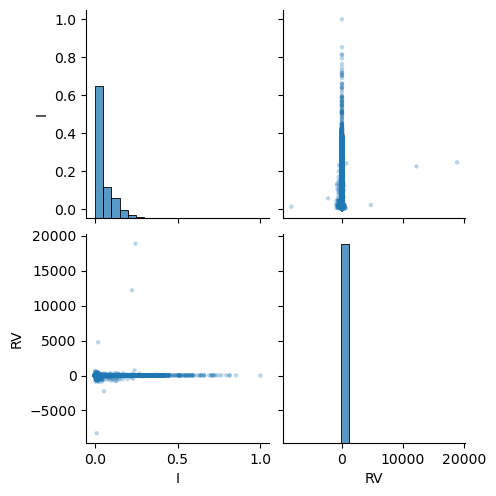

In [10]:
sns.pairplot(data, 
             vars=["I","RV"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )

In [11]:
n = 2.0
mask = (data.I > 0.1) & (data.RV > data.RV.mean() - n*data.RV.std()) & (data.RV < data.RV.mean() + n*data.RV.std())

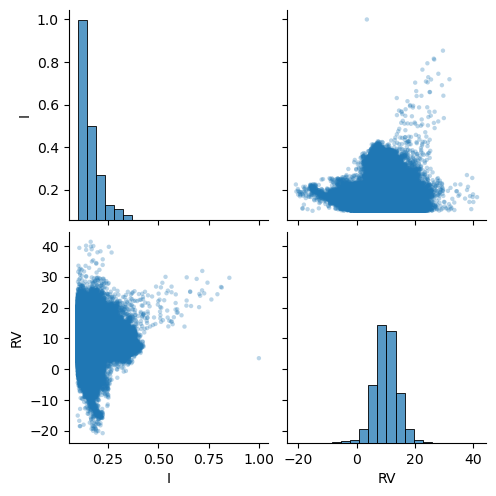

In [12]:
sns.pairplot(data[mask], 
             vars=["I","RV"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )

In [13]:
data[mask].describe()

,X,Y,RV,I
count,457666.000000,457666.000000,457666.000000,457666.000000
mean,738.925896,930.906480,10.079317,0.156924
std,223.516332,221.720336,3.909433,0.053783
min,246.000000,182.000000,-20.807648,0.100000
25%,563.000000,795.000000,7.708535,0.117771
50%,724.000000,941.000000,10.091618,0.140597
75%,925.000000,1096.000000,12.510821,0.179890
max,1238.000000,1400.000000,41.371842,1.000000


In [14]:
sb_mask = (data[mask].round(2)).pivot(index='Y', columns='X', values='I')
vv_mask = (data[mask].round(2)).pivot(index='Y', columns='X', values='RV')

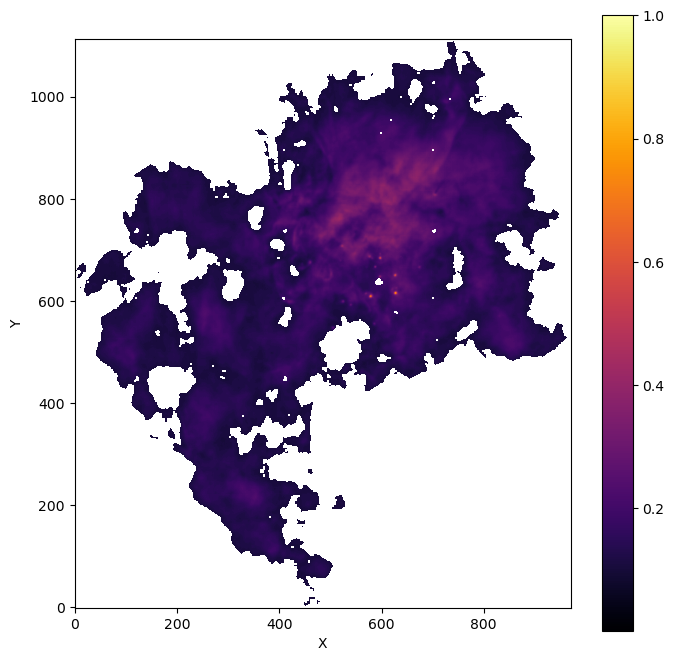

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.figure(1)
plt.imshow(sb_mask, cmap='inferno')

cbar = plt.colorbar()
plt.clim(0.001,1)
cbar.set_label(' ', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

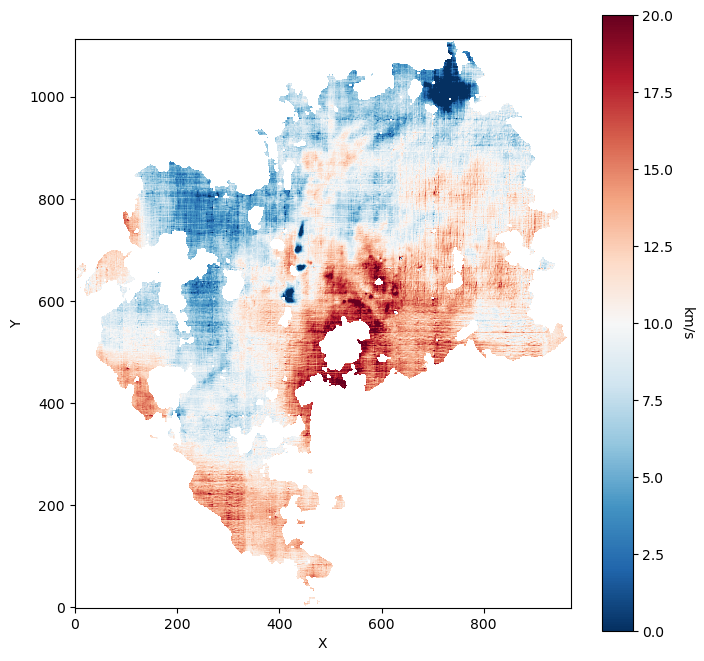

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.figure(1)
plt.imshow(vv_mask, cmap='RdBu_r')

cbar = plt.colorbar()
plt.clim(0,20)
cbar.set_label('km/s', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

In [17]:
xxx

NameError: name 'xxx' is not defined

In [ ]:
sb = np.array(sb_mask)
vv = np.array(vv_mask)

In [ ]:
## Replace spurious values in the arrays
m = ~np.isfinite(sb*vv) | (sb < 0.0)

sb[m] = 0.0
vv[m] = np.nanmean(vv)
sb /= sb.max()

good = (~m) & (sb > 0.001)

In [ ]:
box_size = np.sqrt(sb.shape[0] * sb.shape[1]) * pix * pc

In [ ]:
rslt = strucfunc.strucfunc_numba_parallel(vv, wmap=sb, dlogr=0.05)

In [ ]:
box_size = np.sqrt(sb.shape[0] * sb.shape[1]) * pix * pc

In [ ]:
rslt = strucfunc.strucfunc_numba_parallel(vv, wmap=sb, dlogr=0.05)

In [ ]:
rslt["Unweighted mean velocity"] = np.mean(vv[good])
rslt["Unweighted sigma^2"] = np.var(vv[good])
v0w = rslt["Weighted mean velocity"] = np.average(vv, weights=sb)
rslt["Weighted sigma^2"] = np.average((vv - v0w)**2, weights=sb)

In [ ]:
b2 = rslt['Unweighted B(r)']
b2w = rslt['Weighted B(r)']
e_b2 = b2  *.1
e_b2w = b2w  *.1

s = 10**rslt['log10 r'] * pix * pc
e_s = s  *.1
sig2 = rslt['Unweighted sigma^2']
sig2w = rslt['Weighted sigma^2']

sig = sig2**0.5

In [ ]:
m = 1.2
noise = 0.01


fig, ax = plt.subplots(figsize=(8, 6))
rgrid = np.logspace(-3, .1)
ax.errorbar(s, b2, yerr=e_b2, xerr=e_s, fmt='o', alpha=0.4,color="blue")
ax.errorbar(s, b2w, yerr=e_b2w, xerr=e_s, fmt='x', alpha=0.4,color="green")

ax.set(xscale='log', yscale='log', 
       xlabel='separation, pc',
       ylabel=r'$b^2,\ \mathrm{km^2\ s^{-2}}$'
      )
None

#sig2, r0, m

In [ ]:
results = {
    'sig2' : sig2,
          } 

In [ ]:
data_export = {   
        's' : s,
        'b2' : b2,
        'b2w' : b2w,
        'pc' : pc,
        'pix' : pix,
        'box_size': box_size,
        'results':results,
        'SF' : rslt,
        'SB' : sb,
        'VF' : vv,
}

In [ ]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [ ]:
jsonfilename = name + "_mask.json"
with open(jsonfilename, "w") as f:
    json.dump(data_export, fp=f, indent=3, cls=MyEncoder)

In [ ]:
print("--- %s seconds ---" % (time.time()-start_time))